In [3]:
#%pip install joblib

In [22]:
import pandas as pd
import re 
import seaborn as sns
import pylab as plt
import numpy as np
from joblib import Parallel, delayed
from matplotlib import colors

Data Dictionary:

**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** - amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [5]:
df = pd.read_csv(r"C:\Users\manue\OneDrive\Escritorio\Ironhack\Proyectos\Untitled Folder\Fraud.csv\Fraud.csv")

In [6]:
for i in df.columns:
    print(df[i].value_counts())
    print('-----------------')
    print('-----------------')
    print('-----------------')

19     51352
18     49579
187    49083
235    47491
307    46968
       ...  
432        4
706        4
693        4
112        2
662        2
Name: step, Length: 743, dtype: int64
-----------------
-----------------
-----------------
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64
-----------------
-----------------
-----------------
10000000.00    3207
10000.00         88
5000.00          79
15000.00         68
500.00           65
               ... 
8513.48           1
189137.90         1
1615.78           1
128891.19         1
12257.89          1
Name: amount, Length: 5316900, dtype: int64
-----------------
-----------------
-----------------
C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
              ..
C98968405      1
C720209255     1
C1567523029    1
C644777639     1
C1280323807    1
Name: nameOrig, Length: 6353307, dtype: int64
-----------------
-----------------

In [7]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameorig        object 
 4   oldbalanceorg   float64
 5   newbalanceorig  float64
 6   namedest        object 
 7   oldbalancedest  float64
 8   newbalancedest  float64
 9   isfraud         int64  
 10  isflaggedfraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [10]:
df.isna().sum()

step              0
type              0
amount            0
nameorig          0
oldbalanceorg     0
newbalanceorig    0
namedest          0
oldbalancedest    0
newbalancedest    0
isfraud           0
isflaggedfraud    0
dtype: int64

In [11]:
df.describe()

,step,amount,oldbalanceorg,newbalanceorig,oldbalancedest,newbalancedest,isfraud,isflaggedfraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


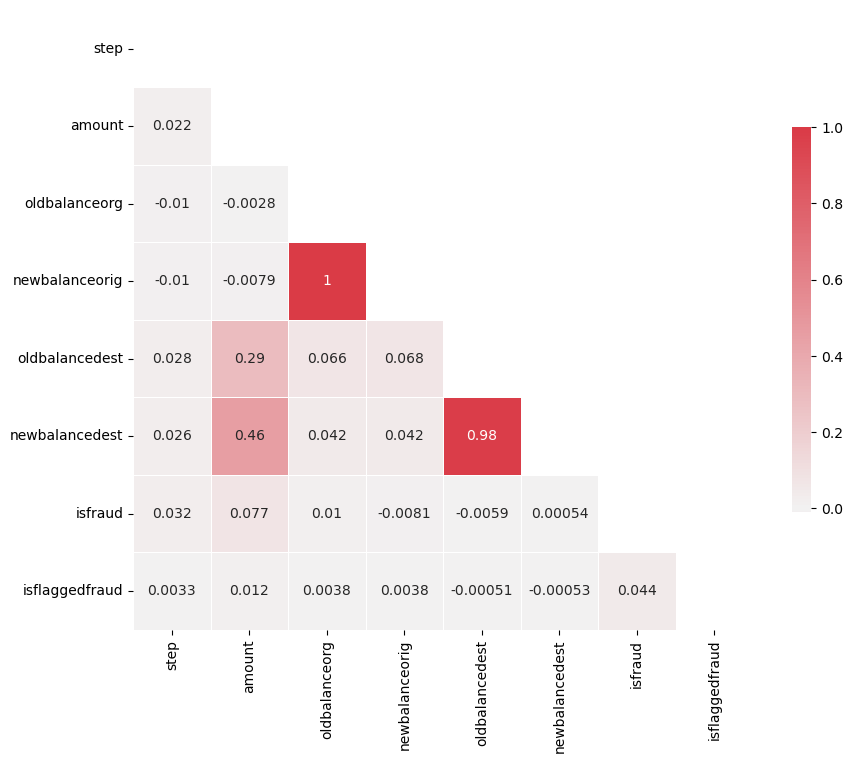

In [12]:
fig, ax=plt.subplots(figsize=(10,10))


mask=np.triu(np.ones_like(df.corr(), dtype=bool))           # mask for superior triangular matrix


color_map=sns.diverging_palette(0, 10, as_cmap=True)   # color palette


# correlation heatmap
sns.heatmap(df.corr(),                       # data
            mask=mask,                  # white mask
            cmap=color_map,             # color
            vmax=1,                     # vertical edge
            center=0,                   # plot center
            square=True,                # data square representation
            annot=True,                 #Para ver el valor de correlacion en cada cuadro     
            linewidth=.5,               # linewidth
            cbar_kws={'shrink': .5},    # lateral bar legend
            ax=ax                       # axes for plot size
           );

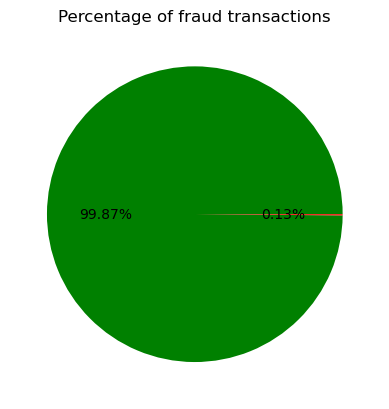

In [28]:
colors_list = ['green', 'red']
# Crea la paleta personalizada
cmap = colors.ListedColormap(colors_list)

plt.pie(df['isfraud'].value_counts(), colors=cmap(range(2)), autopct='%.2f%%')
plt.title('Percentage of fraud transactions')

plt.show()

In [38]:
df.type.value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

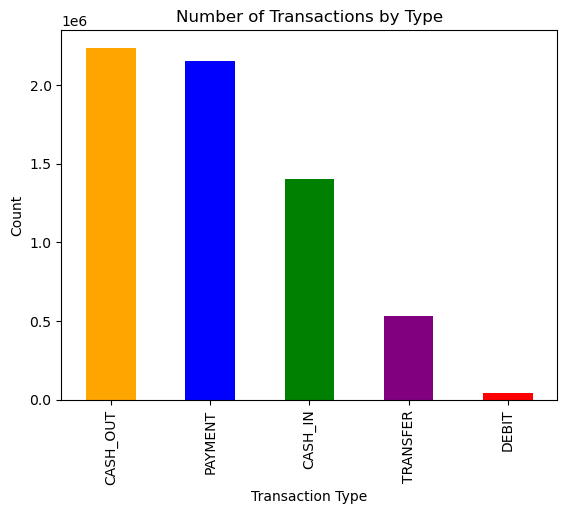

In [43]:
color_list2 = ['orange', 'blue', 'green', 'purple', 'red']
df['type'].value_counts().plot(kind='bar', color = color_list2)
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.title('Number of Transactions by Type')
plt.show()

In [56]:
check_200 = df[df['amount'] > 200000]

In [57]:
#Transacciones de + de 200k que estan catalogadas como fraude
check_200[check_200['isfraud'] == 1]

,step,type,amount,nameorig,oldbalanceorg,newbalanceorig,namedest,oldbalancedest,newbalancedest,isfraud,isflaggedfraud
724,1,CASH_OUT,416001.33,C749981943,0.00,0.0,C667346055,102.00,9291619.62,1,0
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.0,C431687661,0.00,0.00,1,0
970,1,CASH_OUT,1277212.77,C467632528,1277212.77,0.0,C716083600,0.00,2444985.19,1,0
2301,1,TRANSFER,235238.66,C1872047468,235238.66,0.0,C116289363,0.00,0.00,1,0
2302,1,CASH_OUT,235238.66,C1499825229,235238.66,0.0,C2100440237,0.00,235238.66,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


In [58]:
check_under200 = df[df['amount'] < 200000]

In [59]:
#Transacciones de menos de 200k que son fraude
check_under200[check_under200['isfraud'] == 1]

,step,type,amount,nameorig,oldbalanceorg,newbalanceorig,namedest,oldbalancedest,newbalancedest,isfraud,isflaggedfraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362597,741,CASH_OUT,48442.88,C1706094385,48442.88,0.0,C2109905271,513746.19,562189.07,1,0
6362604,742,TRANSFER,54652.46,C1674778854,54652.46,0.0,C1930074465,0.00,0.00,1,0
6362605,742,CASH_OUT,54652.46,C43545501,54652.46,0.0,C830041824,0.00,54652.46,1,0
6362610,742,TRANSFER,63416.99,C778071008,63416.99,0.0,C1812552860,0.00,0.00,1,0


In [65]:
#Todas las transacciones que estan catalogadas como fraude y señaladas como fraude son de mas de 200k
df[(df['isflaggedfraud'] == 1) & (df['isfraud'] == 1)]

,step,type,amount,nameorig,oldbalanceorg,newbalanceorig,namedest,oldbalancedest,newbalancedest,isfraud,isflaggedfraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


In [67]:
df.namedest.value_counts()

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M1470027725      1
M1330329251      1
M1784358659      1
M2081431099      1
C2080388513      1
Name: namedest, Length: 2722362, dtype: int64

In [78]:
namedest = df[df['isfraud'] == 1]

In [82]:
namedest

,step,type,amount,nameorig,oldbalanceorg,newbalanceorig,namedest,oldbalancedest,newbalancedest,isfraud,isflaggedfraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


In [81]:
namedest.namedest.value_counts()

C1193568854    2
C104038589     2
C200064275     2
C1497532505    2
C1601170327    2
              ..
C317811789     1
C24324787      1
C1053414206    1
C2013070624    1
C873221189     1
Name: namedest, Length: 8169, dtype: int64